# *Causal inference using tensor-product smoothing splines with structured latent confounders*

*Simon Dirmeier <simon.dirmeier @ protonmail com>*<br>
*September 2021*

While catching up on new literature on causal inference, I discovered a paper for inference of potential outcomes when
observations are confounded in a hierarchical way, i.e., when a latent confounding variable is shared among several observations <span>(Witty <i>et al.</i>, (2020))</span>. The paper uses Gaussian processes (GPs) to elegantly model the functional relationships between data and latent variables and, following <span>D'Amour, (2019)</span>, shows that the estimator of the individual treatment effect (ITE) is consistent. Even though consistency of an estimator is a desirable property, for finite data variables of interest are often only weakly identifiable when working with complex nonparametric models (at least in my experience) and the utility of otherwise elegant models for principled statistical data analysis is limited. Unfortunately, the paper neither provides any code to redo the analysis nor shows sampler diagnostics or nor visualizations of posterior distributions.

Hence, in this case study, we will first re-implement the proposed model, examine its MCMC diagnostics, and finally propose a model that is both significantly faster to fit and produces easier posterior geometries to sample from. We implement the models in [Stan](https://github.com/stan-dev/stan).

**Feedback and comments are welcome!**

We load some libraries for inference and working with data first.

In [1]:
import sys
import warnings 
import logging

def timer(func):
    from timeit import default_timer    
    def f(*args, **kwargs):
        start = default_timer()
        res = func(*args, **kwargs)
        stop = default_timer()
        print(f"Elapsed time: {stop - start}")
        return res
    return f
  
warnings.filterwarnings('ignore')  
logging.basicConfig(level=logging.ERROR, stream=sys.stdout)

In [2]:
import os
import pandas as pd
import numpy as onp

import jax
from jax import jit
import jax.numpy as np
import jax.scipy as sp
import jax.random as random

from cmdstanpy import CmdStanModel

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import palettes

sns.set_style(
    "ticks", 
    {'font.family':'serif', 
     'font.serif':'Times New Roman'}
)
palettes.set_theme()

## Hierarchical confounding

<span>Witty <i>et al.</i> (2020)</span> assume a structural equations model of the following form

$$\begin{align}
u_o & \leftarrow \epsilon_{u_o} \\
x_i & \leftarrow f_X\left(u_{o = \text{Pa}(i)},  \epsilon_{x_i} \right) \\
t_i & \leftarrow f_{T}\left(u_{o = \text{Pa}(i)}, x_i, \epsilon_{t_i} \right) \\
y_i & \leftarrow f_{Y}\left(u_{o = \text{Pa}(i)}, x_i, t_i, \epsilon_{y_i} \right) \\
\end{align}$$

where $o =1, \dots, N_O$ indexes the number of latent confounders $U_o$, $i = 1, \dots, N_I$ indexes covariables
$X_i$, treatments $T_i$ and outcomes $Y_i$ all of which we assume to be univariate for simplicity, but w.l.o.g can also be multivariate.

Before we define the model from <span>Witty <i>et al.</i>, 2020</span>, we generate some data to define the problem we are dealing with. We first define the sample sizes, number of latent confounders, dimensionality of $X$ and $U$ and noise variances:

In [3]:
N_O = 20
N_I = N_O * 10
P_X = P_U = 1

sigma_u = sigma_x = sigma_tr = sigma_y = 0.1

In [4]:
i_to_o = np.repeat(np.arange(N_O), int(N_I / N_O))

We then sample data following a synthetic evaluation from the paper.

In [5]:
rng_key = random.PRNGKey(23)

In [6]:
rng_key, sample_key = random.split(rng_key, 2)
U = random.multivariate_normal(
    sample_key, 
    mean=np.zeros(P_U),
    cov=np.eye(P_U) * sigma_u,
    shape=(N_O,)
)

In [7]:
rng_key, sample_key = random.split(rng_key, 2)
X_eps = random.multivariate_normal(
    sample_key, 
    mean=np.zeros(P_X),
    cov=np.eye(P_X) * sigma_x,
    shape=(N_I,)    
)
X = U[i_to_o] + X_eps

In [8]:
def gt(x, u, i_to_o):
    xs = np.sum(x * np.sin(x), axis=1)
    us = np.sum(u[i_to_o] * np.sin(u[i_to_o]), axis=1)
    return xs - us
  
rng_key, sample_key = random.split(rng_key, 2)
tr_eps = random.normal(
    sample_key, 
    shape=(N_I,)
) * sigma_tr
tr = gt(X, U, i_to_o) + tr_eps

In [9]:
def gy(t, x, u, i_to_o):
    ts = t * np.sin(2 * t)
    xs = np.sum(x * np.sin(x), axis=1)
    us = np.sum(u[i_to_o] * np.sin(u[i_to_o]), axis=1)
    return ts + xs + 3 * us
  
rng_key, sample_key = random.split(rng_key, 2)
y_eps = random.normal(
    sample_key, 
    shape=(N_I,)
) * sigma_y
y = gy(tr, X, U, i_to_o) + y_eps

Let's visualize this. Note that the functional relationship between $U$ and any other variable $X, T, Y$ is - similar to a factor model - basically discrete, since $N_O < N_I$.

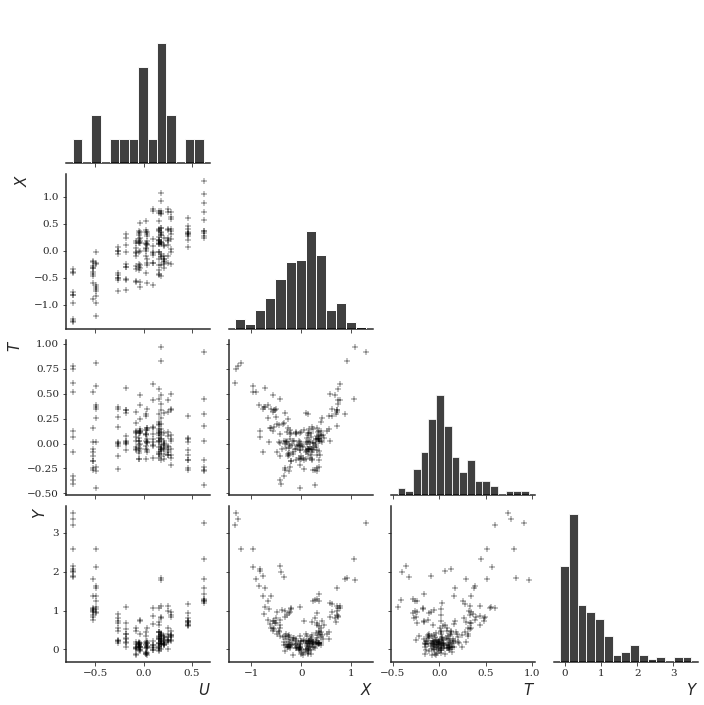

In [10]:
pld = pd.DataFrame(
    {"$U$": U[i_to_o, 0], "$X$": X[:,0], "$T$": tr, "$Y$": y}
)

_ = sns.pairplot(
    pld,
    palette="black",
    plot_kws=dict(marker="+", color="black"),
    diag_kws=dict(color="black"),
    corner=True
)
plt.show()

For Stan, we wrap the data into a dictionary:

In [11]:
data = {
    "N_I": N_I,
    "N_O": N_O,
    "i_to_o": onp.asarray(i_to_o + 1),
    "X": onp.asarray(np.squeeze(X)),
    "tr": onp.asarray(tr),
    "y": onp.asarray(y),
    "alpha": 5.0,
    "beta": 5.0
}

In addition, we define a sampling method such that we can time inference of posterior distributions of a model. We sample a total of $3000$ times on two separate chains of which we discard the first $1000$ samples which is usually more than enough for HMC.

In [12]:
def sample(model, data, iter_warmup=1000, iter_sampling=2000):
    return model.sample(
        data=data, 
        iter_warmup=iter_warmup,
        iter_sampling=iter_sampling,
        chains=2, 
        parallel_chains=2, 
        show_progress=False,
        seed=23
    )

We also define a function to compile a model:

In [13]:
def compile(model_file):
    model = CmdStanModel(stan_file=model_file)
    return model

## A Gaussian process model

<span>Witty <i>et al.</i> (2020)</span> propose a semi-parametric model that models every structural equation using a GP (if I translate this correctly from the paper)

\begin{align}
\rho & \sim \text{InvGamma}(5, 5) \\
\sigma & \sim \text{HalfNormal}(1) \\
u & \sim  \text{MvNormal}(0, \sigma_U^2 I) \\
x & \sim \text{GP}\left(0, K_X\left(u_{o = \text{Pa}(i)}, u_{o = \text{Pa}(i)}\right) + \sigma_X^2 I \right) \\
t & \sim \text{GP}\left(0, K_T\left(\left[u_{o = \text{Pa}(i)}, x_i \right], \left[u_{o = \text{Pa}(i)}, x_i \right]\right) + \sigma_T^2 I \right) \\
y & \sim \text{GP}\left(0, K_Y\left(\left[u_{o = \text{Pa}(i)}, x_i, t_i \right], \left[u_{o = \text{Pa}(i)}, x_i, t_i \right]\right) + \sigma_Y^2 I \right) \\
\end{align}

where the notation $[a, b]$ concatenates the row-vectors $a$ and $b$ along the same axis and every covariance function $K_k$ is an exponentiated-quadratic covariance function with automatic relevance determination, i.e., for every dimension of a feature vector a separate length-scale is introduced. For instance, $K_X\left(u_{o = \text{Pa}(i)}, u_{o = \text{Pa}(i)}\right)$ for univariate $u$ and $i$ uses three hyperparamters.

On first view, this model seems difficult to fit with common probabilistic languages and Hamiltonian Monte Carlo. 
The regression of $X$ on $U$ is a Gaussian process latent variable model which is in itself is not trivial to work with, even though to help identify the kernel parameters of $K_X$ statistical strength can be borrowed from the regressions of $T$ and $Y$ onto $U$. In addition, the posterior geometry looks to be challenging to explore due to the high number of positively-constrained parameters and the somewhat awkward covariance structure of $K_X\left(u_{o = \text{Pa}(i)}, u_{o = \text{Pa}(i)}\right)$. Lastly, for low sample sizes both $u$ and the kernel hyperparameters might be only weakly identified (if at all) which for interpretation of the results is undesirable.

Let's try to fit this model.

In [14]:
models_folder = "_models/causal_inference_using_tensor_product_smoothing_splines"
gp_model_file = os.path.join(
    models_folder, "gp_model.stan"
)

model = compile(gp_model_file)
fit = sample(model, data)

ERROR:cmdstanpy:Chain 1 terminated by signal -2
 error message:
	Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: gp_exp_quad_cov: magnitude is inf, but must be positive finite! (in '/home/simon/PROJECTS/_etudes/_models/causal_inference_using_tensor_product_smoothing_splines/gp_model.stan', line 57, column 4 to line 59, column 56)
If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: cholesky_decompose: Matrix m is not positive definite (in '/home/simon/PROJECTS/_etudes/_models/causal_inference_using_tensor_product_smoothing_splines/gp_model.stan', line 60, column 4 to column 49)
If this warning occurs sporadic

KeyboardInterrupt: 

The fit was tremendously slow which is usually a sign of a very unfavourable posterior geometry. Let's have a look at posterior diagnostics.

In [ ]:
print(fit.diagnose())

Let's also have a look at the energy plot and a trace plot of $U$ and $\sigma_U$.

In [ ]:
posterior_az = az.from_cmdstanpy(fit)

_, ax = plt.subplots(figsize=(8, 3))
_ = az.plot_energy(
    posterior_az,
    ax=ax, 
    fill_color=["#233B43", "darkgrey"]
);
_ = ax.legend(title="", bbox_to_anchor=(1.2, 0.5))
plt.show()

In [ ]:
_, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
_ = az.plot_trace(
    posterior_az,
    axes=axes,
    var_names=["u_scale", "U"],
    chain_prop={"color": palettes.discrete_qualitative_colors(2)}
)
plt.show()

The MCMC diagnostics are worrisome. Not only did the chains not mix, the effective sample size of some parameters is approximately one. We could just sample longer chains, increase the `tree-depth` or decrease `adapt-delta`, but this model seems too pathological to fit successfully (at least for this data set).

I assume the low effective sample size when using HMC was one of the reasons why the authors used an elliptical slice sampler for the confounders. They note however: "*[the model] tends to underestimate the uncertainty in [the counterfactual] estimates. In other words, the posterior density on the ground-truth counterfactual is sometimes low, despite the fact that the mean estimate is close to the ground-truth relative to the baselines. We suspect that this is partially attributable to inaccuracies resulting from our approximate inference procedure*". Hence, it might very well be that their sampling scheme produces the same pathological result (which warrants the question why they didn't include diagnostics given that the model seems either ill-defined or at least hard to work with in practice, and given that there are apparently *inaccuracies resulting from our approximate inference procedure*).

## A second GP model

The inference of $U$ seems to be problematic. Let's try a simpler model, where we replace the GP regression of $X$ on $U$ with a single linear predictor:

$$\begin{align}
\rho & \sim \text{InvGamma}(5, 5) \\
\sigma & \sim \text{HalfNormal}(1) \\
u & \sim \text{MvNormal}(0, \sigma_U^2 I) \\
\beta & \sim  \text{Normal}(0, 1) \\
x_i & \sim \text{Normal}\left(u_{o = \text{Pa}(i)}\beta, \sigma_X^2 \right) \\
t & \sim \text{GP}\left(0, K_T\left(\left[u_{o = \text{Pa}(i)}, x_i \right], \left[u_{o = \text{Pa}(i)}, x_i \right]\right) + \sigma_T^2 I \right) \\
y & \sim \text{GP}\left(0, K_Y\left(\left[u_{o = \text{Pa}(i)}, x_i, t_i \right], \left[u_{o = \text{Pa}(i)}, x_i, t_i \right]\right) + \sigma_Y^2 I \right) \\
\end{align}$$

This change is somewhat sensible. This $N_O < N_I$ we cannot really estimate a smooth function anyway.

Let's try fitting this model.

In [ ]:
gplinear_model_file = os.path.join(
    models_folder, "gp+linear_model.stan"
)

model = compile(gplinear_model_file)
fit = sample(model, data)

The fit was a bit faster. What are the diagnostics saying?

In [ ]:
print(fit.diagnose())

In [ ]:
posterior_az = az.from_cmdstanpy(fit)

_, ax = plt.subplots(figsize=(8, 3))
_ = az.plot_energy(posterior_az, ax=ax, fill_color=["#233B43", "darkgrey"]);
_ = ax.legend(title="", bbox_to_anchor=(1.2, 0.5))
plt.show()

The chains still don't seem to converge. The effective sample sizes are worrisome, too. Apparently the GP hyperparameter still do not allow efficiently exploring the posterior manifold.

## A tensor-product spline model

Both models seem to be too hard to sample from to make work in practice and draw statistically reliable conclusions for decision making. As a final approach we simplify the model one more time and replace all functional GP relationships with smoothing splines. Since the regressions $f: U, X \rightarrow T$ and $f: U, X, T \rightarrow Y$ use vectorial inputs, we will use a tensor-product smoothing spline <span>(Wood (2006))</span> based on B-spline bases. 

A spline with of order $m + 1$ with $K$ parameters can be represented as a linear combination of B-spline bases as

$$\begin{equation}
f(x) = \sum_i^K \alpha_i B_{i, m}(x)
\end{equation}$$

where $B_i^m$ are defined recursively via

$$\begin{equation}
B_{i, 1}(x) = \begin{cases}
    1 & \text{if } k_i \le x < k_{i + 1}\\
    0 & \text{otherwise}
\end{cases}
\end{equation}$$

and

$$\begin{equation}
B_{i, m}(x)_ = \frac{x - k_i}{k_{i + m + 1} - k_i} B_{i, m - 1}(x) + \frac{k_{i + m + 2} - x}{k_{i + m + 2} - k_{i + 1}} B_{i + 1, m - 1}(x)
\end{equation}$$

To define a B-spline basis with $K$ parameters and order $m + 1$ we will need to define a $K + m + 2$-dimensional vector of knots $k$ (which in practice can be a bit annoying). 
As Milad Kharratzadeh notes in his [spline case study](https://mc-stan.org/users/documentation/case-studies/splines_in_stan.html), we should define an extended knot sequence to cover the whole span of the knots, but for this case-study we follow the description in <span>Wood (2017)</span> to avoid confusion.

To build a B-spline basis in Stan we consequently need to implement this recursive definition. Since this definition only handles univariate inputs, we will use a tensor-product basis over multiple variables. 
Following <span>Wood (2006)</span>, the constructions of a tensor-product basis starts by constructing low-rank bases $B^V$ for every variable $V$. We then define a tensor-product spline over a set of variables as

$$\begin{equation}
f(x, y; \alpha) = \sum_k^K \sum_l^L \alpha_{kl} B^X_{k,m} B^Y_{l,m}
\end{equation}$$
We can extend this construction further for a third variable

$$\begin{equation}
f(x, y, z; \alpha) = \sum_k^K \sum_l^L \sum_j^J \alpha_{klj} B^X_{k,m} B^Y_{l,m}  B^Z_{j,m}
\end{equation}$$

This construction is all we need to define a smooth functions over the three variables. For our model, we will use B-spline bases which are not necessarily low-rank. However, by regularize adjacent pairs of coefficients $\alpha$ to control the wiggliness of the basis function (see <span>Wood (2017)</span> who explains this way better). 

Let's test these two models. First we simulate data and fit a conventional B-spline.

In [ ]:
tn = 100
tx = np.linspace(-3, 2, tn)
ty_mean  = 2 * np.sin(tx)
ty = ty_mean + random.normal(
  random.PRNGKey(0), shape=(tn,)
) * 0.25

tdata = {
    "N": tn,
    "X": onp.asarray(tx),
    "y": onp.asarray(ty),
    "degree": 2,
    "n_knots": 6,
    "knots": onp.linspace(-4, 4, 6)
}

tps_file = os.path.join(models_folder, "b_spline.stan")
model = compile(tps_file)
fit = model.sample(data=tdata, chains=2)
ty_star = np.mean(fit.draws_pd(vars="y_hat").values, axis=0)

_, ax = plt.subplots(figsize=(8, 3))
_ = ax.scatter(tx, ty, marker="+", color="black")
_ = ax.plot(
    tx,
    ty_star, 
    color=palettes.discrete_qualitative_colors(4)[2]
)
plt.show()

Then we simulate a regression model with two covariables and fit a tensor-product smoother with B-spline bases.

In [ ]:
tn = 100
tx1 = np.linspace(-3, 2, tn)
tx2 = np.linspace(3, -2, tn)
ty_mean  = tx1 * np.sin(tx1) - np.cos(tx2)
ty = ty_mean + random.normal(
  random.PRNGKey(0), shape=(tn,)
) * 0.25

tdata = {
    "N": tn,
    "X": onp.asarray(np.vstack([tx1, tx2])).T,
    "y": onp.asarray(ty),
    "degree": 2,
    "n_knots": 6,
    "x1_knots": onp.linspace(-4, 4, 6),
    "x2_knots": onp.linspace(-4, 4, 6)
}

tps_file = os.path.join(models_folder, "tp_spline.stan")
model = compile(tps_file)
fit = model.sample(data=tdata, chains=2)
ty_star = np.mean(fit.draws_pd(vars="y_hat").values, axis=0)

_, axes = plt.subplots(figsize=(12, 4), ncols=2)
for i, (ax, tx) in enumerate(zip(axes, [tx1, tx2])):
    _ = axes[i].scatter(tx, ty, marker="+", color="black")
    _ = axes[i].plot(
        tx,
        ty_star, 
        color=palettes.discrete_qualitative_colors(4)[2]
    )
plt.show()

This worked nicely! The fit is not as good as with a Gaussian process but easy to fit. 

Replacing the GPs in our causal structural model with smoothing splines yields the following generative model:

\begin{align}
\sigma & \sim \text{HalfNormal}(1.0) \\
u & \sim  \text{MvNormal}(0, \sigma_U^2 I) \\
\beta_X & \sim  \text{Normal}(0, 1) \\
x_i & \sim \text{Normal}\left(u_{o = \text{Pa}(i)}\beta_X, \sigma_X^2 \right) \\
\beta_{T0} & \sim \text{Normal}(0, 1) \\
\beta_{Ti} & \sim \text{Normal}(\beta_{T,i-1}, \sigma_{\beta_T}) \\
t_i & \sim \text{Normal}\left(f\left(u_{o = \text{Pa}(i)}, x_i\right)^T \beta_T, \sigma_T^2 I \right) \\
\beta_{Y0} & \sim \text{Normal}(0, 1) \\
\beta_{Yi} & \sim \text{Normal}(\beta_{Y,i-1}, \sigma_{\beta_Y}) \\
y_i & \sim \text{Normal}\left(f\left(u_{o = \text{Pa}(i)}, x_i, t_i\right)^T \beta_Y, \sigma_Y^2 I \right) \\
\end{align}

where $f(\dots; \dots)$ are penalized tensor-product smoothers with B-spline bases as defined above.

Before fitting this, we need to define the order of the spline, or equivalently its degree, and a sequence of knots for every variable. For $X$ we can just use quantiles. For $U$ which is latent we use quantiles of a normal with standard deviation $2$ which should cover the entire domain of the posterior. For $T$ which is the treatment, we want to make counterfactual predictions when we increase the treatment in the next steps. Hence we compute the quantiles on all values of $T$ and th $T + 1$. This is arguably a bit awkward, but we need to make sure to cover the entire domain to have a well defined spline basis.
We choose a degree of $d=2$, since the pair plots of the data above suggest approximately quadratic relationship (at least since we assume to not know the data generating process).

In [ ]:
data["degree"] = 2
data["n_knots"] = 6

quantiles = np.linspace(0.001, 0.999, data["n_knots"])
u_knots = sp.stats.norm.ppf(loc=0, scale=2, q=quantiles)
x_knots = np.quantile(X, q=quantiles)
tr_knots = np.quantile(np.concatenate([tr, tr + 1]), q=quantiles)

data["u_knots"] = onp.asarray(u_knots)
data["x_knots"] = onp.asarray(x_knots)
data["tr_knots"] = onp.asarray(tr_knots)

We can now fit the model

In [ ]:
tps_model_file = os.path.join(models_folder, "tps_model.stan")

model = compile(tps_model_file)
fit = sample(model, data)

The fit is significantly faster. Let's have a look at some diagnostics.

In [ ]:
print(fit.diagnose())

Diagnostics look excellent.

In [ ]:
fit.summary()

Let's also look at some plots.

In [ ]:
posterior_az = az.from_cmdstanpy(fit)

_, ax = plt.subplots(figsize=(8, 3))
_ = az.plot_energy(
    posterior_az, 
    ax=ax,
    fill_color=["#233B43", "darkgrey"]
);
_ = ax.legend(title="", bbox_to_anchor=(1.2, 0.5))
plt.show()

In [ ]:
_, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
_ = az.plot_trace(
    posterior_az,
    axes=axes,
    var_names=["u_scale", "U"],
    chain_prop={"color": palettes.discrete_qualitative_colors(2)}
)
plt.show()

With Stan we can generate simulations from the posterior predictive. Below, we simulated predictive ITE values using the posterior samples as defined in the paper.

In [ ]:
ite = gy(tr + 1, X, U, i_to_o) - y

ite_star = fit.draws_pd(vars="ite")
ite_star = np.quantile(
  ite_star.values,
  axis=0, 
  q=np.array([0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95])
)

_, ax = plt.subplots(figsize=(8, 3))
_ = sns.histplot(ite, color="#233B43", ax=ax, stat="density", bins=30)
for i in range(ite_star.shape[0]):
    _ = sns.kdeplot(
        ite_star[i, :],
        color=palettes.discrete_qualitative_colors(3)[2],
        ax=ax
    )
plt.show()

## License

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img align="left" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a> <br><br>

The case study is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

## Session info

In [ ]:
import session_info
session_info.show(html=False)

## Stan files

In [ ]:
print(open(os.path.join(models_folder, "functions.stan"), "r").read())

In [ ]:
print(open(tps_model_file, "r").read())

# References

D’Amour, Alexander. 2019. “On Multi-Cause Causal Inference with Unobserved Confounding: Counterexamples, Impossibility, and Alternatives.” arXiv Preprint arXiv:1902.10286.

Witty, Sam, Kenta Takatsu, David Jensen, and Vikash Mansinghka. 2020. “Causal Inference Using Gaussian Processes with Structured Latent Confounders.” In International Conference on Machine Learning, 10313–23. PMLR.

Wood, Simon N. 2006. “Low-Rank Scale-Invariant Tensor Product Smooths for Generalized Additive Mixed Models.” Biometrics 62 (4): 1025–36.

Wood, Simon N. 2017. Generalized Additive Models: An Introduction with R. CRC press.